# Лабораторная работа №1
**Цель работы**

Изучить возможности библиотек Python для решения задач цифровой обработки сигналов.

**Задачи лабораторной работы**

1. Освоить Jupyter Notebook.
2. Выполнить загрузку аудио сигнала и построить огибающую (график).
3. Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.
4. Детектор сигнал/шум. Получить сигнал после детектирования.
5. Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.
6. Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

In [ ]:
# DONT DO THIS

!pip3 install matplotlib

In [2]:
from scipy.io import wavfile
rate, binary = wavfile.read("03-01-05-01-01-02-13_A13.wav")

/var/folders/jp/vxbf15d97m11tnt0y7_x15dh0000gn/T/ipykernel_957/1453104292.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, binary = wavfile.read("./Downloads/03-01-05-01-01-02-13_A13.wav")


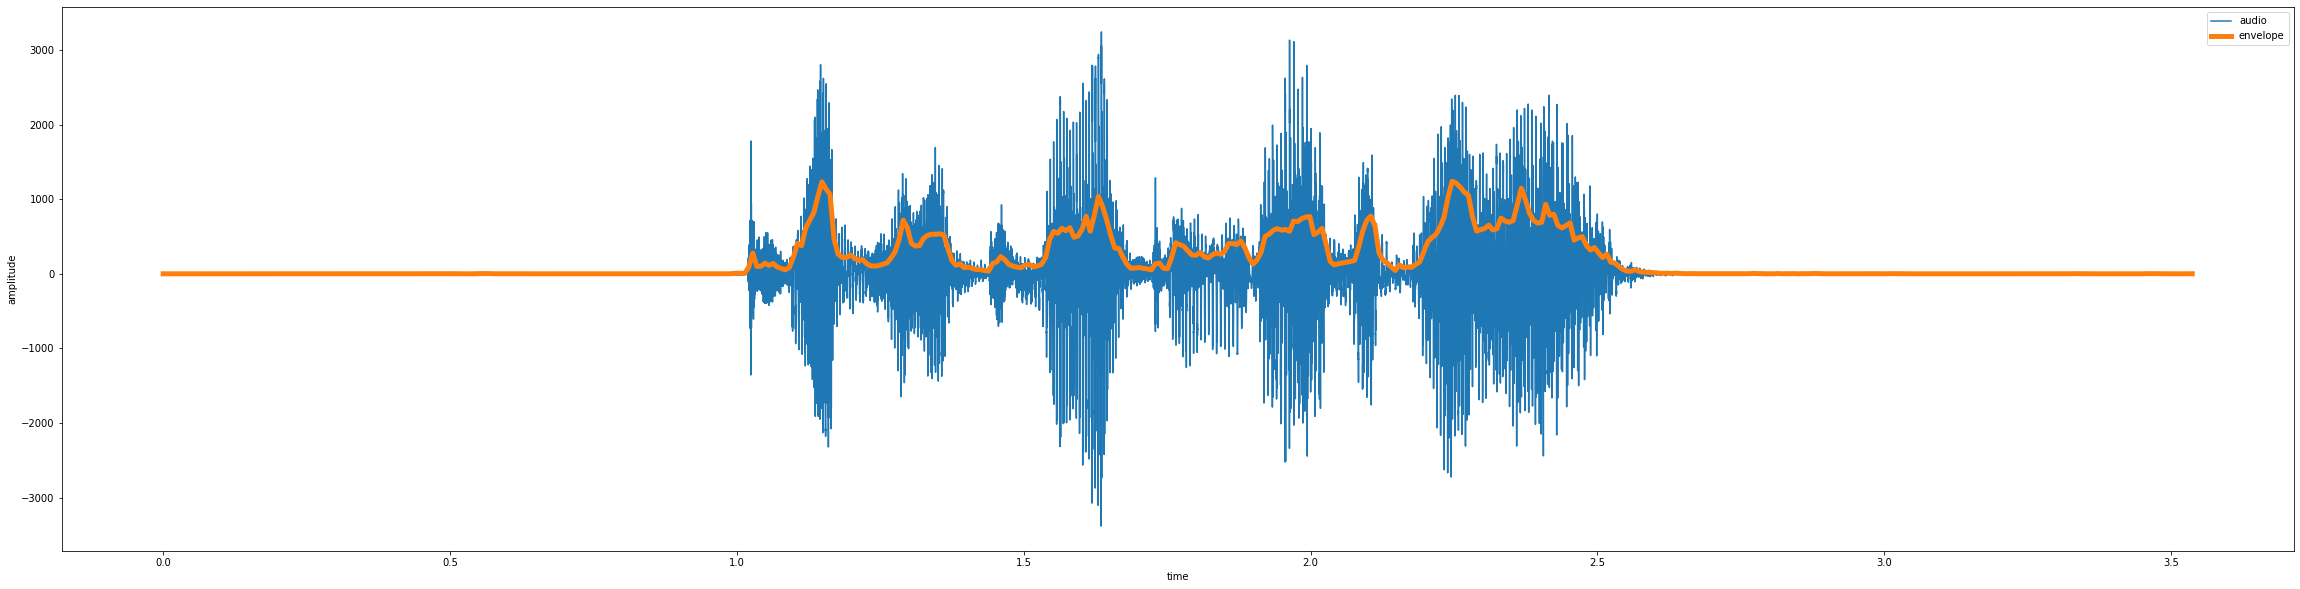

In [3]:
import matplotlib.pyplot as plt
import numpy as np


dots = 500
duration = binary.size / rate
time_interval = np.linspace(0, duration, binary.size)
m = binary.size // dots

envelope_interval = np.linspace(0, duration, dots)
envelope_values = [sum([abs(binary[k]) for k in range(m * j, m * j + m)]) / m for j in range(dots)]
  
figure = plt.figure()
figure.set_figwidth(40)
figure.set_figheight(10)

plt.plot(time_interval, binary, label="audio")
plt.plot(envelope_interval, envelope_values, label="envelope", linewidth=5)

plt.legend()
plt.xlabel("time")
plt.ylabel("amplitude")
plt.show()

# Фильтрация сигнала
Выбрана реализация фильтра высоких частот.
Пусть $F_d$ - частота дискретизации, $F_s$ - частота среза, $m$ - порядок фильтра. Тогда вычисляем $wn$ = $2 * (F_s / F_d)$



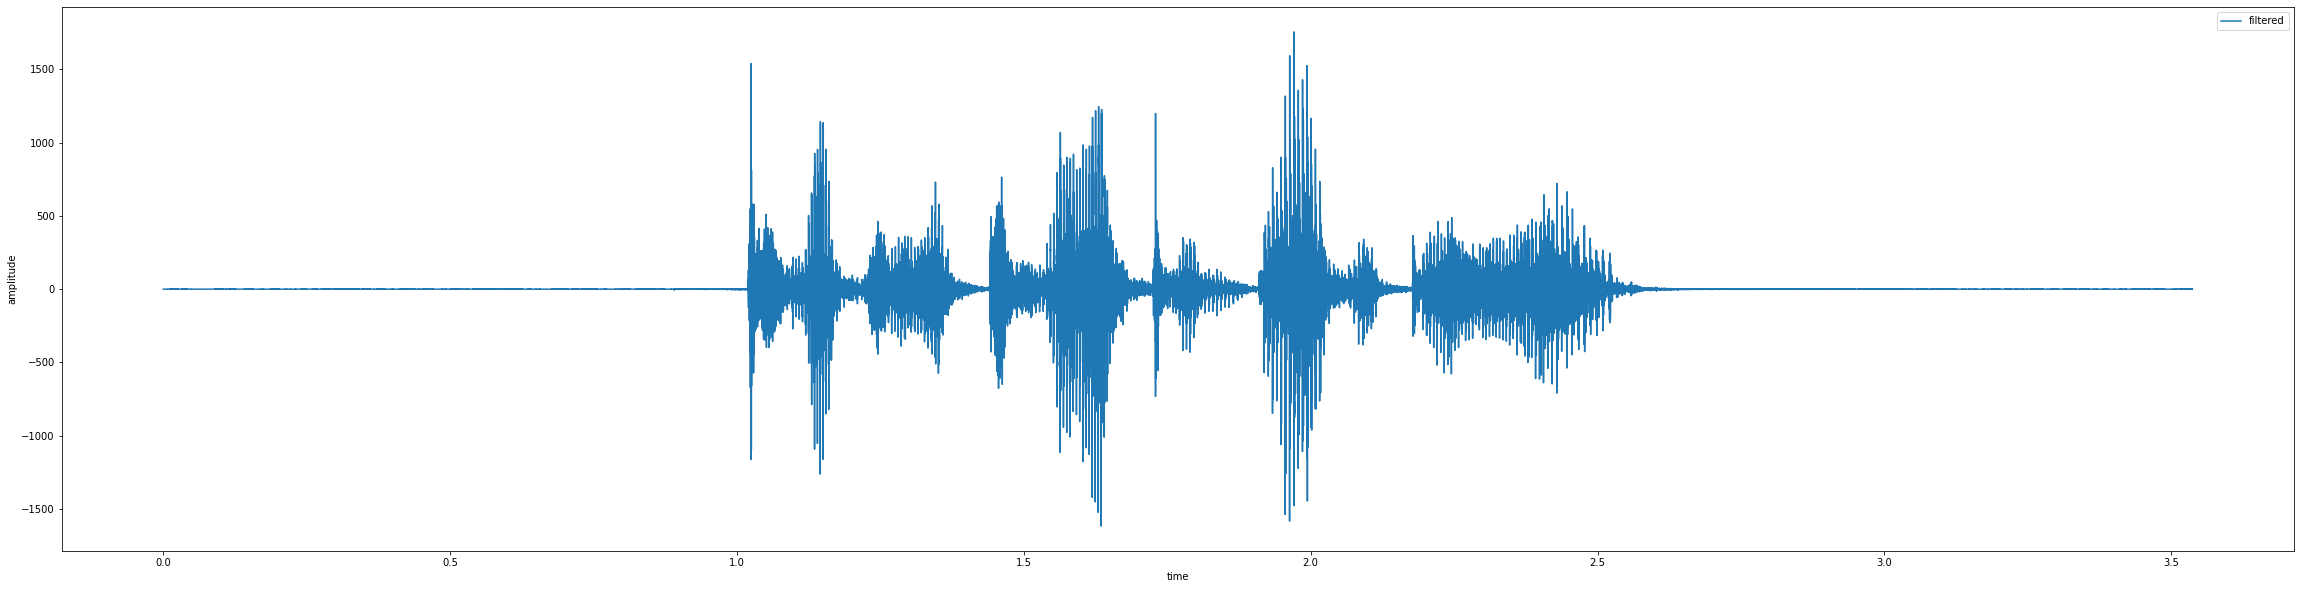

In [4]:
from scipy import signal

m = 1
Fs = 5000

b, a = signal.butter(m, 2 * Fs / binary.size, 'highpass')
filtered = signal.filtfilt(b, a, binary)

figure = plt.figure()
figure.set_figwidth(40)
figure.set_figheight(10)

plt.plot(time_interval, filtered, label="filtered")
plt.legend()
plt.xlabel("time")
plt.ylabel("amplitude")
plt.show()

# Амплитудный детектор сигнал/шум

Определяем среднее сигнала по амплитуде (без учета знака): 
$mid = \frac{1} N \displaystyle\sum^{N-1}_{k=0}|x(k)|$

Определяем порог детектора - $Th = \alpha ∗ mid$, где $0 < \alpha < 1$ подбирается экспериментально. Задаем величину ”провала” (в отсчетах) — $k$. Обозначим $y(i)$ — сигнал после детектирования.

$\cdot$ Событие ”начало сигнала”. Если $x(i)$ в течение $k$ отсчетов превышает порог, $y(i) = x(i)$.

$\cdot$ Событие ”окончание сигнала”. Если $x(i)$ в течение $k$ отсчетов меньше порога, $y(i) = 0$.

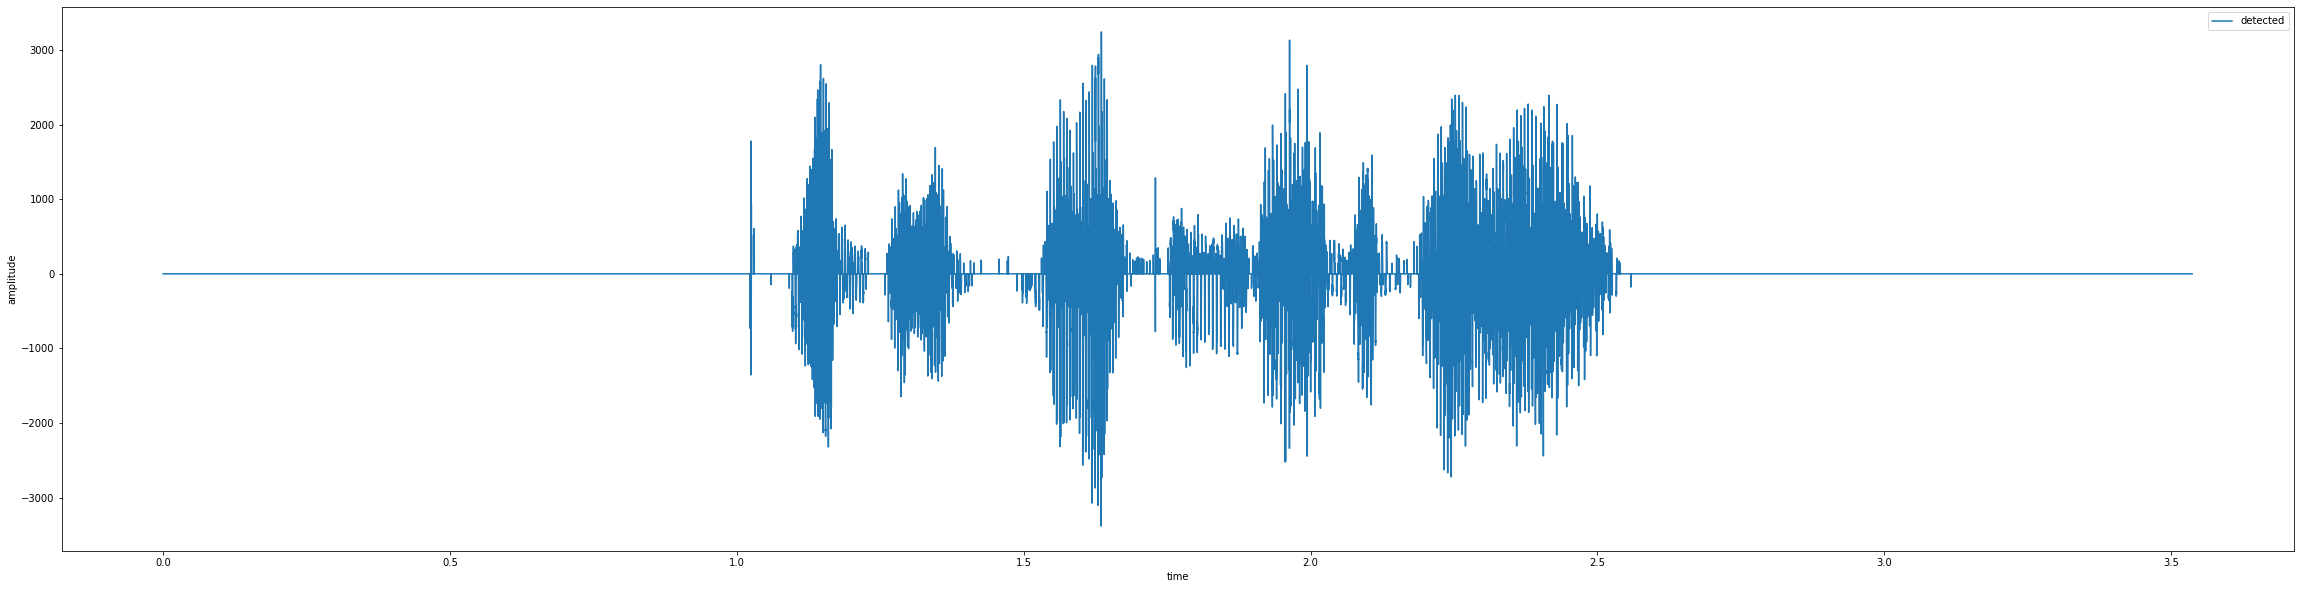

In [5]:
middle = sum(map(abs, binary)) / binary.size
alpha = 0.8
Th = middle * alpha

k = 10
y = np.zeros(binary.size)

count_success = 0
count_unsuccess = 0

for i in range(binary.size):
    
    if abs(binary[i]) > Th:
        count_success += 1
        count_unsuccess = 0
    else:
        count_unsuccess += 1
        count_success = 0
        
    if count_success >= k:
        y[i] = binary[i]

figure = plt.figure()
figure.set_figwidth(40)
figure.set_figheight(10)
plt.plot(time_interval, y, label="detected")
plt.legend()
plt.xlabel("time")
plt.ylabel("amplitude")
plt.show()

## Эффект ”Эхо”

$\cdot$ Ревербератор реализован, как набор линий задержки. Число линий задержки $N_{L} \geq 8$.
Каждая линия задержки имеет свой весовой коэффициент (задается пользователем): $\alpha_{1} > \alpha_{2} > \dots > \alpha_{N_{L}}$.

$\cdot$ Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.

$\cdot$ Желаемое соотношение между ”сухим” и обработанным сигналом задается коэффициентом применимости $\gamma$.

$\cdot$ Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset). Для ручного режима регулируется пользователем задается максимальная задержка $D_1$ , а величины остальных определяются автоматически через нее:

$D_i = D_1 2 \frac{1-i} {N_L}, i = 2, \dots, N_L$.

Для готовой конфигурации пользователь вручную задает последовательность $D_1 > D_2 > \dots > D_{N_L}$.

Введите 'yes', если желаете ввести задержку самостоятельно: no
Введите максимальную задержку: 100000


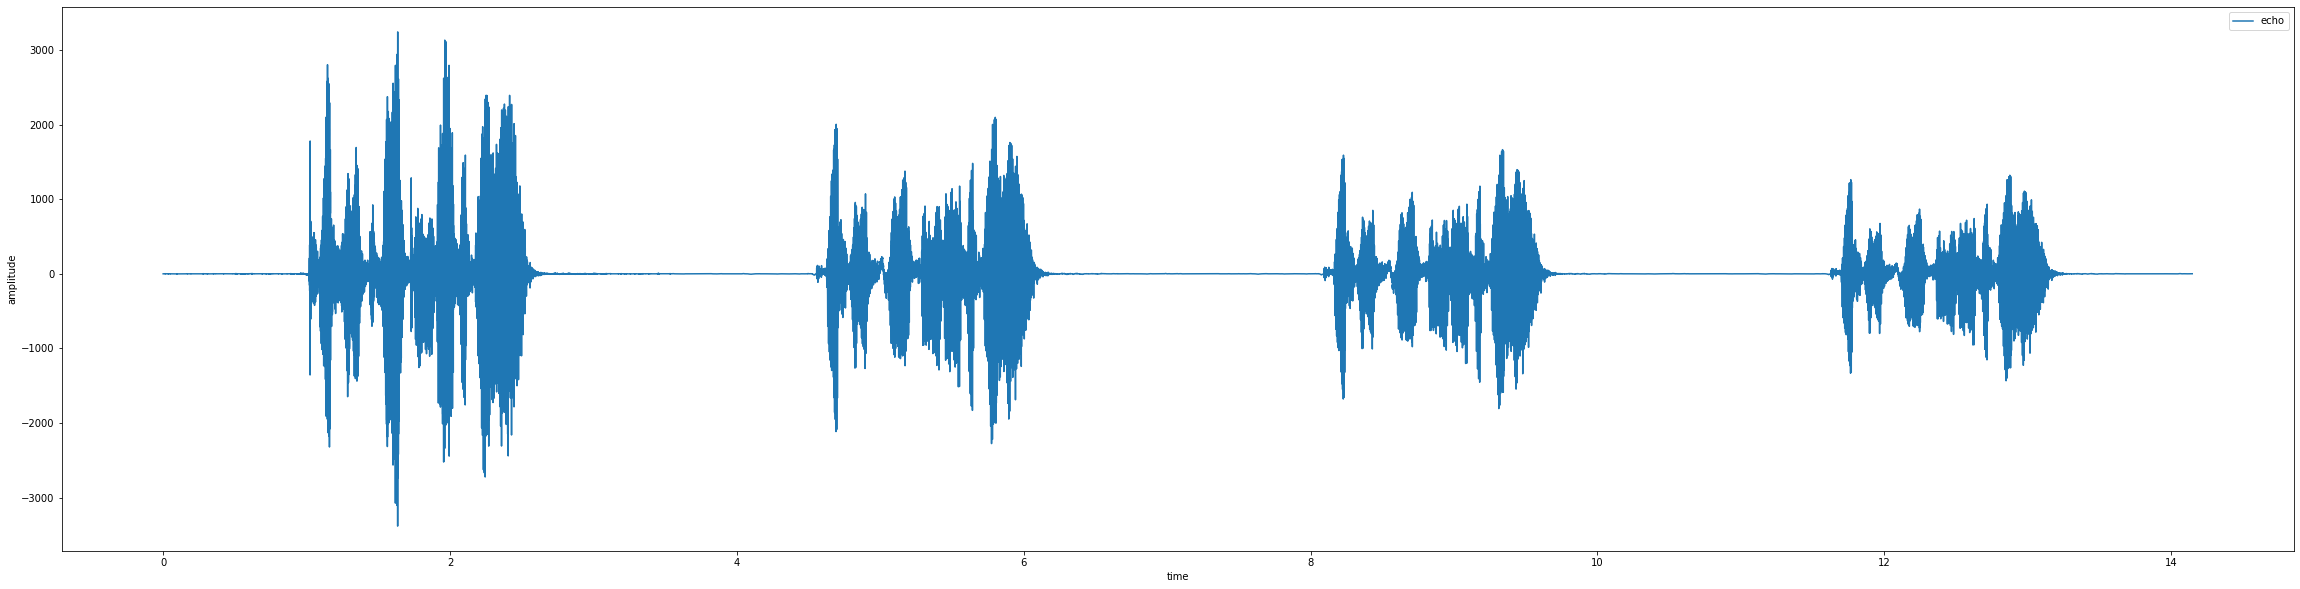

In [28]:
def user_input():
    
    N = int(input("Введите количество линий задержки: "))
    array = []
    current_delay = 0
    
    while current_delay != N:
        try:
            d = int(input(f"[{current_delay + 1}] Введите задержку: "))
            if not current_delay:
                array.append(d)
            else:
                if d < array[current_delay - 1]:
                    array.append(d)
                else:
                    raise TypeError
            current_delay += 1
        except TypeError:
            print("Не удалось использовать данное значение, повторите ввод.")
    
    return array


DEFAULT_DELAY_LINES = 3

mode = 0
if input("Введите 'yes', если желаете ввести задержку самостоятельно: ") == 'yes':
    mode = 1
    
if not mode:
    first = int(input("Введите максимальную задержку: "))
    count_lines = DEFAULT_DELAY_LINES
    delays = [first * 2 ** ((1 - i) / count_lines) for i in range(2, count_lines + 1)]
    delays = np.insert(delays, 0, first)
else:
    delays = user_input()
    count_lines = len(delays)


array = np.zeros(binary.size * (count_lines + 1))
array[:binary.size] = binary
gamma = 0.7

    
additional = np.zeros(binary.size * count_lines)
for index in range(len(delays)):
  delay = delays[index]
  alphai = delay / rate
    
  xi = binary * alphai
  additional[index * binary.size : (index + 1) * binary.size] = xi[:]
    
    
Fs = 600
m = 1
wn = 2 * Fs / rate

b, a = signal.butter(m, wn, 'lowpass')
filtered_data = signal.filtfilt(b, a, additional)
additional = filtered_data * gamma
array[binary.size:] = additional

f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.plot(np.linspace(0, duration * (count_lines + 1), binary.size * (count_lines + 1)), array, label="echo")
plt.legend()
plt.xlabel("time")
plt.ylabel("amplitude")
plt.show()

## Эффект ”Distortion

Обозначим входной сигнал и выходной сигналы - $x(i)$ и $y(i)$ соответственно. $i = 0,1, \dots, N − 1$. 

Пользователь задает порог — $Th$ и максимальное значение сигнала $Max > Th$. 
Тогда $y(i) = \begin{cases} x(i), |x(i)| \leq Th, \\ Max * sign(x(i)), |x(i)| > Th\end{cases}$

Введите порог: 300
Введите максимальное значение сигнала: 900


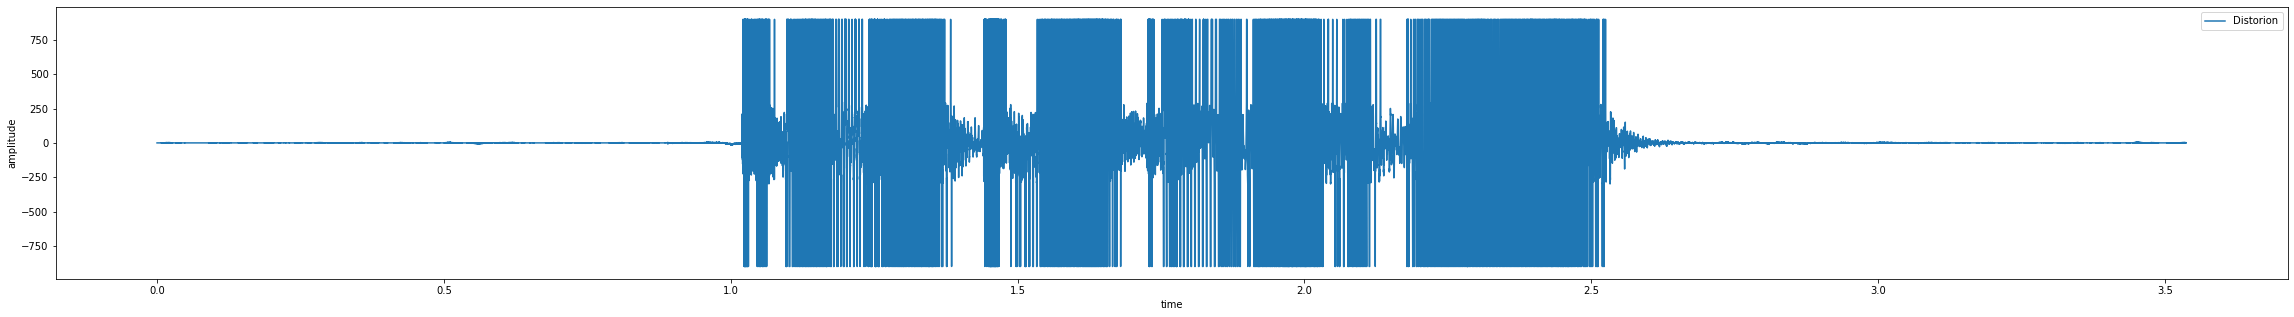

In [39]:
Th = int(input("Введите порог: "))
Max = int(input("Введите максимальное значение сигнала: "))

yi = np.zeros(binary.size)

for index in range(binary.size):
    if abs(binary[index]) < Th:
        yi[index] = binary[index]
    else:
        yi[index] = Max * np.sign(binary[index])
   
figure = plt.figure()
figure.set_figwidth(40)
figure.set_figheight(5)
plt.plot(time_interval, yi, label="Distorion")
plt.legend()
plt.xlabel("time")
plt.ylabel("amplitude")
plt.show()

## Выводы по лабораторной работе

Была освоена работа со средой Jupyter Notebook, а также с математическими пакетами языка Python. Для лабораторной работы были использованы следующие пакеты: matplotlib, numpy, scipy. Получены навыки обработки и визуализации звуковых сигналов.